# Full Transfer Functions

In [1]:
%load_ext autoreload
import sys
sys.path.append("..")

In [2]:
%autoreload

import matplotlib
matplotlib.rc_file('matplotlibrc')
import matplotlib.pyplot as plt

%matplotlib inline

matplotlib.rcParams['figure.figsize'] = [10,10]


from astropy.io import fits

import numpy as np
import copy
import pickle

import darkhistory.physics as phys
import darkhistory.utilities as utils
import darkhistory.spec.spectools as spectools
import darkhistory.spec.transferfunction as tf
import darkhistory.spec.transferfunclist as tflist
from darkhistory.spec.spectrum import Spectrum
from darkhistory.spec.spectra import Spectra
import darkhistory.history.tla as tla

from scipy.interpolate import interp1d

from tqdm import tqdm_notebook as tqdm

from darkhistory.electrons.ics.ics_spectrum import ics_spec
from darkhistory.electrons.ics.ics_engloss_spectrum import engloss_spec
from darkhistory.electrons.ics.ics_cooling import get_ics_cooling_tf

from darkhistory.low_energy.lowE_deposition import compute_fs

# np.set_printoptions(threshold=np.nan)

In [3]:
# mDM = 1e11
# sigmav = 1e-24

# def rate_func_swave(rs):
#     return 0*phys.inj_rate('swave', rs, mDM=mDM, sigmav=sigmav)/(2*mDM)

# def test(rs, x1, x2, x3):
#     return 0.3

# test = tla.get_history(
#                 np.array([phys.TCMB(3000), 1, 0, 0]), 0.3, 0.3, 0.3, 
#                 rate_func_swave, np.flipud(np.arange(1, 3001)), reion_switch=False
#             )

# out = np.stack((np.flipud(np.arange(1, 3001)), test[:,0], test[:,1]))
# # pickle.dump(
# #     out, open("/Users/hongwan/GitHub/DarkHistory/darkhistory/history/std_soln.p", "wb")       
# #            )

In [4]:
soln = pickle.load(open("../darkhistory/history/std_soln.p", "rb"))
xe_std  = interp1d(soln[0,:], soln[2,:])
T_m_std = interp1d(soln[0,:], soln[1,:])

In [5]:
rs = 600
print(xe_std(rs))
print(T_m_std(rs)/phys.kB)
print(phys.TCMB(rs)/phys.kB)

0.0009648017275850074
1625.56121532
1635.2995445551107


In [11]:
# plt.figure()

# plt.plot(np.flipud(np.arange(1, 3001)), test[:,0]/phys.kB)
# plt.plot(np.flipud(np.arange(1, 3001)), phys.TCMB(np.flipud(np.arange(1, 3001)))/phys.kB, 'k:')
# ax = plt.gca()

# ax.set_xscale('log')
# ax.set_yscale('log')

# plt.figure()

# plt.plot(np.flipud(np.arange(1, 3001)), test[:,1])
# ax = plt.gca()

# ax.set_xscale('log')
# ax.set_yscale('log')

## Photon Transfer Functions

In [ ]:
user = '/Users/GregoryRidgway/Downloads/'

# highengphot_tflist_arr = pickle.load(open("/Users/"+user+"/Dropbox (MIT)/Photon Deposition/tfunclist_photspec_60eV_complete_coarse.raw", "rb"))
# lowengphot_tflist_arr  = pickle.load(open("/Users/"+user+"/Dropbox (MIT)/Photon Deposition/tfunclist_lowengphotspec_60eV_complete_coarse.raw", "rb"))
# lowengelec_tflist_arr  = pickle.load(open("/Users/"+user+"/Dropbox (MIT)/Photon Deposition/tfunclist_lowengelecspec_60eV_complete_coarse.raw", "rb"))
# CMB_engloss_arr = pickle.load(open("/Users/"+user+"/Dropbox (MIT)/Photon Deposition/CMB_engloss_60eV_complete_coarse.raw", "rb"))

highengphot_tflist_arr = pickle.load(open(user+"tfunclist_photspec_60eV_complete_coarse.raw", "rb"))
lowengphot_tflist_arr  = pickle.load(open(user+"tfunclist_lowengphotspec_60eV_complete_coarse.raw", "rb"))
lowengelec_tflist_arr  = pickle.load(open(user+"tfunclist_lowengelecspec_60eV_complete_coarse.raw", "rb"))
CMB_engloss_arr = pickle.load(open(user+"CMB_engloss_60eV_complete_coarse.raw", "rb"))

In [8]:
highengphot_tflist_arr[0]._grid_vals.shape

(51, 325, 500)

In [9]:
photeng = highengphot_tflist_arr[0].eng
eleceng = lowengelec_tflist_arr[0].eng

#Split photeng into high and low energy. 
photeng_high = photeng[photeng > 60]
photeng_low  = photeng[photeng <= 60]

# Split eleceng into high and low energy. 
eleceng_high = eleceng[eleceng > 3000]
eleceng_low  = eleceng[eleceng <= 3000]


for highengphot_tflist in highengphot_tflist_arr:
    
#     highengphot_tflist.at_val('in_eng', photeng_high, bounds_error=False, fill_value=0)

    for tf in highengphot_tflist:
        # tf.rebin(photeng_high)
#         tf.rebin(photeng)
        
        # Pad with zeros so that it becomes photeng x photeng. 
        tf._grid_vals = np.pad(tf.grid_vals, ((photeng_low.size, 0), (0, 0)), 'constant')
        tf._N_underflow = np.pad(tf._N_underflow, (photeng_low.size, 0), 'constant')
        tf._eng_underflow = np.pad(tf._eng_underflow, (photeng_low.size, 0), 'constant')
        tf._in_eng = photeng
        tf._eng = photeng
        tf._rs = tf.rs[0]*np.ones_like(photeng)
    
    highengphot_tflist._eng = photeng
    highengphot_tflist._in_eng = photeng
    highengphot_tflist._grid_vals = np.atleast_3d(
        np.stack([tf.grid_vals for tf in highengphot_tflist._tflist])
    )
    
# lowengphot_tflist.in_eng set to photeng_high
for lowengphot_tflist in lowengphot_tflist_arr:
    
#     lowengphot_tflist.at_val('in_eng', photeng_high, bounds_error=False, fill_value=0)
    
    for tf in lowengphot_tflist:
#         tf.rebin(photeng)
        # Pad with zeros so that it becomes photeng x photeng. 
        tf._grid_vals = np.pad(tf.grid_vals, ((photeng_low.size,0), (0,0)), 'constant')
        # Photons in the low energy bins should be immediately deposited.
        tf._grid_vals[0:photeng_low.size, 0:photeng_low.size] = np.identity(photeng_low.size)
        tf._N_underflow = np.pad(tf._N_underflow, (photeng_low.size, 0), 'constant')
        tf._eng_underflow = np.pad(tf._eng_underflow, (photeng_low.size, 0), 'constant')
        tf._in_eng = photeng
        tf._eng = photeng
        tf._rs = tf.rs[0]*np.ones_like(photeng)
    
    lowengphot_tflist._eng = photeng
    lowengphot_tflist._in_eng = photeng
    lowengphot_tflist._grid_vals = np.atleast_3d(
        np.stack([tf.grid_vals for tf in lowengphot_tflist._tflist])
    )
    
# lowengelec_tflist.in_eng set to photeng_high 
for lowengelec_tflist in lowengelec_tflist_arr:
    
#     lowengelec_tflist.at_val('in_eng', photeng_high, bounds_error=False, fill_value=0)
    
    for tf in lowengelec_tflist:
#         tf.rebin(eleceng)
        # Pad with zeros so that it becomes photeng x eleceng. 
        tf._grid_vals = np.pad(tf.grid_vals, ((photeng_low.size,0), (0,0)), 'constant')
        tf._N_underflow = np.pad(tf._N_underflow, (photeng_low.size, 0), 'constant')
        tf._eng_underflow = np.pad(tf._eng_underflow, (photeng_low.size, 0), 'constant')
        tf._in_eng = photeng
        tf._eng = eleceng
        tf._rs = tf.rs[0]*np.ones_like(photeng)

    lowengelec_tflist._eng = eleceng
    lowengelec_tflist._in_eng = photeng
    lowengelec_tflist._grid_vals = np.atleast_3d(
        np.stack([tf.grid_vals for tf in lowengelec_tflist._tflist])
    )
    
    for engloss in CMB_engloss_arr:
        engloss = np.pad(engloss, ((0,0),(photeng_low.size, 0)), 'constant')


In [10]:
xes = 0.5 + 0.5*np.tanh([-5., -4.1, -3.2, -2.3, -1.4, -0.5, 0.4, 1.3, 2.2, 3.1, 4])


In [6]:
# highengphot_tf_interp = tflist.TransferFuncInterp(xes, highengphot_tflist_arr)
# lowengphot_tf_interp = tflist.TransferFuncInterp(xes, lowengphot_tflist_arr)
# lowengelec_tf_interp = tflist.TransferFuncInterp(xes, lowengelec_tflist_arr)


phot_spec_init = spectools.rebin_N_arr(np.array([2]), 
                                      np.array([1e11]), 
                                      photeng)
phot_spec_init.switch_spec_type()


NameError: name 'photeng' is not defined

In [17]:
phot_spec_init.rs = 3000
end_rs   = 2950
mDM = 1e8
sigmav = 1e-26
tau = 1e24

def rate_func_swave_N(rs):
    # This is dN/dV dt
    return phys.inj_rate('swave', rs, mDM=mDM, sigmav=sigmav)/(2*mDM)

def rate_func_swave_eng(rs):
    # This is dN/dV dt
    return phys.inj_rate('swave', rs, mDM=mDM, sigmav=sigmav)

def rate_func_decay_N(rs):
    # This is dN/dV dt
    return phys.inj_rate('decay', rs, tau=tau)/mDM

def rate_func_decay_eng(rs):
    # This is dN/dV dt
    return phys.inj_rate('decay', rs, tau=tau)


def rate_func_swave_N_2(rs):
    # This is dN/dV dt
    return phys.inj_rate('swave', rs, mDM=mDM, sigmav=sigmav*1e-30)/(2*mDM)

def rate_func_swave_eng_2(rs):
    # This is dN/dV dt
    return phys.inj_rate('swave', rs, mDM=mDM, sigmav=sigmav*1e-30)


def evolve(
    in_spec_elec, in_spec_phot, 
    rate_func_N, rate_func_eng, xe_init, T_m_init,
    highengphot_tf_interp, lowengphot_tf_interp, 
    lowengelec_tf_interp, 
    end_rs, coarsen_factor=1, std_soln=False
):
    """
    Main function that computes the temperature and ionization history. 
    
    Parameters
    ----------
    in_spec_elec : Spectrum
        Spectrum per annihilation/decay into electrons. 
    in_spec_phot : Spectrum
        Spectrum per annihilation/decay into photons.
    rate_func_N : function
        Function describing the rate of annihilation/decay, dN/(dV dt)
    rate_func_eng : function
        Function describing the rate of annihilation/decay, dE/(dV dt)
    xe_init : float
        xe at the initial redshift. 
    T_m_init : float
        Matter temperature at the initial redshift. 
    highengphot_tf_interp : TransferFuncInterp
        Interpolation table for high energy photons. 
    lowengphot_tf_interp : TransferFuncInterp
        Interpolation table for low energy photons. 
    lowengelec_tf_interp : TransferFuncInterp
        Interpolation table for low energy electrons. 
    end_rs : float
        Final redshift to evolve to. 
    coarsen_factor : int
        Coarsening to apply to the transfer function matrix. 
    std_soln : bool
        If true, uses the standard TLA solution for f(z). 
    """
    
    # Initialize the next spectrum as None.
    next_highengphot_spec = None
    next_lowengphot_spec  = None
    next_lowengelec_spec  = None
    
    if (
        highengphot_tf_interp.dlnz    != lowengphot_tf_interp.dlnz
        or highengphot_tf_interp.dlnz != lowengelec_tf_interp.dlnz
        or lowengphot_tf_interp.dlnz  != lowengelec_tf_interp.dlnz
    ):
        raise TypeError('TransferFuncInterp objects must all have the same dlnz.')
    
    if in_spec_elec.rs != in_spec_phot.rs:
        raise TypeError('Input spectra must have the same rs.')
    
    # redshift/timestep related quantities. 
    dlnz = highengphot_tf_interp.dlnz
    prev_rs = None
    rs = in_spec_phot.rs
    dt = dlnz/phys.hubble(rs)
    
    # The initial input dN/dE per annihilation to per baryon per dlnz, 
    # based on the specified rate. 
    # dN/(dN_B d lnz dE) = dN/dE * (dN_ann/(dV dt)) * dV/dN_B * dt/dlogz
    
    # ICS for in_spec_elec goes here.
    
    # (Should this be multiplied by dlnz?)
    init_inj_spec = (
        in_spec_phot * rate_func_N(rs) * dt / (phys.nB * rs**3)
    )
    
    
    # Initialize the Spectra object that will contain all the 
    # output spectra during the evolution.
    out_highengphot_specs = Spectra([init_inj_spec], spec_type=init_inj_spec.spec_type)
    out_lowengphot_specs  = Spectra([], spec_type=init_inj_spec.spec_type)
    out_lowengelec_specs  = Spectra([], spec_type=init_inj_spec.spec_type)
    
    # Initialize the xe and T array that will store the solutions.
    xe_arr  = np.array([xe_init])
    T_m_arr = np.array([T_m_init])
    
    # Load the standard TLA solution if necessary. 
#     if std_soln:
    if True:
        soln = pickle.load(open("../darkhistory/history/std_soln.p", "rb"))
        xe_std  = interp1d(soln[0,:], soln[2,:])
        T_m_std = interp1d(soln[0,:], soln[1,:])

    # Define these methods for speed.
    append_highengphot_spec = out_highengphot_specs.append
    append_lowengphot_spec  = out_lowengphot_specs.append
    append_lowengelec_spec  = out_lowengelec_specs.append
    
    # Loop while we are still at a redshift above end_rs.
    while rs > end_rs:
        
        # If prev_rs exists, calculate xe and T_m. 
        if prev_rs is not None:
#             print('here at least?')
            
            # f_continuum, f_lyman, f_ionH, f_ionHe, f_heat
            # f_raw takes in dE/(dV dt)
            if std_soln:
                f_raw = compute_fs(
                    next_lowengelec_spec, next_lowengphot_spec,
                    np.array([1-xe_std(rs), 0, 0]), rate_func_eng(rs), dt
                )
                
            else:
                f_raw = compute_fs(
                    next_lowengelec_spec, next_lowengphot_spec,
                    np.array([1-xe_arr[-1], 0, 0]), rate_func_eng(rs), dt
                )
                
            std_f = compute_fs(
                    next_lowengelec_spec, next_lowengphot_spec,
                    np.array([1-xe_std(rs), 0, 0]), rate_func_eng(rs), dt
                )
            
            backreaction_f = compute_fs(
                    next_lowengelec_spec, next_lowengphot_spec,
                    np.array([1-xe_arr[-1], 0, 0]), rate_func_eng(rs), dt
                )
            
            init_cond = np.array([T_m_arr[-1], xe_arr[-1], 0, 0])

            new_vals = tla.get_history(
                init_cond, f_raw[2], f_raw[1], f_raw[4], 
                rate_func_eng, np.array([prev_rs, rs]),
                reion_switch = False
            )

            T_m_arr = np.append(T_m_arr, new_vals[-1,0])
            xe_arr  = np.append(xe_arr,  new_vals[-1,1])
            
        print('T_m at '+str(rs)+': '+ str(T_m_arr[-1]))
        print('x_e at '+str(rs)+': '+ str(xe_arr[-1]))
        print('Standard x_e at '+str(rs)+': '+str(xe_std(rs)))
        if prev_rs is not None:
            print('Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat: ', backreaction_f)
            print('Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat: ', std_f)
            
        if std_soln:
            highengphot_tf = highengphot_tf_interp.get_tf(rs, xe_std(rs))
            lowengphot_tf  = lowengphot_tf_interp.get_tf(rs, xe_std(rs))
            lowengelec_tf  = lowengelec_tf_interp.get_tf(rs, xe_std(rs))
        else:
            highengphot_tf = highengphot_tf_interp.get_tf(rs, xe_arr[-1])
            lowengphot_tf  = lowengphot_tf_interp.get_tf(rs, xe_arr[-1])
            lowengelec_tf  = lowengelec_tf_interp.get_tf(rs, xe_arr[-1])
        
#         if coarsen_factor > 1:
#             prop_tf = np.zeros_like(highengphot_tf._grid_vals)
#             for i in np.arange(coarsen_factor):
#                 prop_tf += matrix_power(highengphot_tf._grid_vals, i)
#             lowengphot_tf._grid_vals = np.matmul(prop_tf, lowengphot_tf._grid_vals)
#             lowengelec_tf._grid_vals = np.matmul(prof_tf, lowengelec_tf._grid_vals)
#             highengphot_tf._grid_vals = matrix_power(
#                 highengphot_tf._grid_vals, coarsen_factor
#             )
            
        next_highengphot_spec = highengphot_tf.sum_specs(out_highengphot_specs[-1])
        next_lowengphot_spec  = lowengphot_tf.sum_specs(out_highengphot_specs[-1])
        next_lowengelec_spec  = lowengelec_tf.sum_specs(out_highengphot_specs[-1])
        
        # Re-define existing variables.
        prev_rs = rs
        rs = np.exp(np.log(rs) - 0.002)
        
        dt = dlnz/phys.hubble(rs)
        next_highengphot_spec.rs = rs
        next_lowengphot_spec.rs  = rs
        next_lowengelec_spec.rs  = rs
        
        # Add the next injection spectrum to next_highengphot_spec
        next_inj_spec = (
            in_spec_phot * rate_func_N(rs)* dt / (phys.nB * rs**3)
        )
        # This keeps the redshift. 
        next_highengphot_spec.N += next_inj_spec.N
        
        append_highengphot_spec(next_highengphot_spec)
        append_lowengphot_spec(next_lowengphot_spec)
        append_lowengelec_spec(next_lowengelec_spec)
        
        print('************************ END OF LOOP **************************')
        
        
    return (
        xe_arr, T_m_arr, 
        out_highengphot_specs, out_lowengphot_specs, out_lowengelec_specs
    )
        
        
            
        
            
    


In [18]:
%%prun
# a = evolve(
#         phot_spec_init*0, phot_spec_init, 
#         rate_func_decay_N, rate_func_decay_eng, .9999, phys.TCMB(phot_spec_init.rs),
#         highengphot_tf_interp, lowengphot_tf_interp, 
#         lowengelec_tf_interp, 
#         end_rs, coarsen_factor=1, std_soln=False
#     )

b = evolve(
        phot_spec_init*0, phot_spec_init, 
        rate_func_decay_N, rate_func_decay_eng, xe_std(phot_spec_init.rs), phys.TCMB(phot_spec_init.rs),
        highengphot_tf_interp, lowengphot_tf_interp, 
        lowengelec_tf_interp, 
        end_rs, coarsen_factor=1, std_soln=True
    )

T_m at 31: 0.00728082520365
x_e at 31: 0.0002238511528760423
Standard x_e at 31: 0.0002238511528760423
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25524865177564926 0.2848686584344274 0.3149017619408866 0.01936010505004922 0.12562082279898754
Split by photon and electron deposition!
f_phot:  [9.46762163e-05 1.02103065e-05 6.53671689e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [7.36022048e-05 1.67562081e-04 1.86253158e-04 8.43401544e-06
 1.18569851e-04]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25524865177564926 0.2848686584344274 0.3149017619408866 0.01936010505004922 0.12562082279898754
Split by photon and electron deposition!
f_phot:  [9.46762163e-05 1.02103065e-05 6.53671689e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [7.36022048e-05 1.67562081e-04 1.86253158e-04 8.43401544e-06
 1.18569851e-04]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25525454607968945 0.28486528945095496 0.314900

../darkhistory/spec/spectrum.py:748: RuntimeWarning: The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.
  warnings.warn("The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.", RuntimeWarning)


************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2552368943305785 0.28487537865556345 0.31490442224658366 0.01936029123040814 0.1256230135368663
Split by photon and electron deposition!
f_phot:  [2.80657959e-03 8.72224899e-05 4.00692876e-04 0.00000000e+00
 0.00000000e+00]
f_elec:  [3.74222150e-04 8.50259013e-04 9.31942979e-04 4.27444053e-05
 6.27937119e-04]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2552368943305785 0.28487537865556345 0.31490442224658366 0.01936029123040814 0.1256230135368663
Split by photon and electron deposition!
f_phot:  [2.80657959e-03 8.72224899e-05 4.00692876e-04 0.00000000e+00
 0.00000000e+00]
f_elec:  [3.74222150e-04 8.50259013e-04 9.31942979e-04 4.27444053e-05
 6.27937119e-04]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2557516183312356 0.28458125931232553 0.3147878789011597 0.019352157707587078 0.12552708574769192
Split by photon and electron deposition!
f_phot:  [2

Normalized electron heat, lyman, ionH, ionHe, cont:  0.2552018701560189 0.284895397997693 0.3149123465145867 0.019360845951284216 0.125629539380417
Split by photon and electron deposition!
f_phot:  [0.00944293 0.00021882 0.00088    0.         0.        ]
f_elec:  [7.98519619e-04 1.81325784e-03 1.98016122e-03 9.31339921e-05
 1.35316581e-03]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.26120701722234335 0.28147439781890526 0.3135424840737969 0.019267978562069844 0.12450812232288454
Split by photon and electron deposition!
f_phot:  [0.00944293 0.00021882 0.00088    0.         0.        ]
f_elec:  [7.95833729e-04 1.79470323e-03 1.95631363e-03 9.53679961e-05
 1.39601990e-03]
T_m at 30.446992003107383: 0.007335482032957564
x_e at 30.446992003107383: 0.00030373086079088507
Standard x_e at 30.446992003107383: 0.00022333225151189984
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.02387595e-02 2.01351837e-03 2.83631097e-03 9.53679961e-05
 1.39601990e-03]
Standard f_cont, f_

T_m at 30.083811540003854: 0.0075085573620470615
x_e at 30.083811540003854: 0.00039218864717327495
Standard x_e at 30.083811540003854: 0.0002229914701148979
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.01184202 0.00219253 0.00311419 0.00010231 0.00159507]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.01186276 0.00224444 0.00314516 0.0001038  0.00148996]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2551614754924269 0.28491848800567854 0.31492148493593475 0.019361485934900023 0.12563706563105972
Split by photon and electron deposition!
f_phot:  [0.01109031 0.00024283 0.00096157 0.         0.        ]
f_elec:  [0.00088871 0.0020183  0.00220612 0.00010463 0.0015007 ]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2551614754924269 0.28491848800567854 0.31492148493593475 0.019361485934900023 0.12563706563105972
Split by photon and electron deposition!
f_phot:  [0.01109031 0.00024283 0.00

Normalized electron heat, lyman, ionH, ionHe, cont:  0.27817285747049963 0.273086263548671 0.30898934824084834 0.019340978654712078 0.12041055208526891
Split by photon and electron deposition!
f_phot:  [0.01172722 0.00025417 0.00100279 0.         0.        ]
f_elec:  [0.00088091 0.00200851 0.00226298 0.00010265 0.00175817]
T_m at 29.547147399402803: 0.007803425070989678
x_e at 29.547147399402803: 0.0005356345068686097
Standard x_e at 29.547147399402803: 0.0002224813485243171
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.01260812 0.00226268 0.00326576 0.00010265 0.00175817]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.01265497 0.00236123 0.00330593 0.00010935 0.00156591]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25510951412389965 0.2849481911855331 0.31493323861492095 0.019362309494316533 0.12564674658132977
Split by photon and electron deposition!
f_phot:  [0.01179961 0.00025555 0.00100

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2550696415751752 0.2849709850787006 0.31494225668550213 0.019362941698089334 0.1256541749625327
Split by photon and electron deposition!
f_phot:  [0.01231127 0.00026548 0.00104425 0.         0.        ]
f_elec:  [0.00096367 0.00218867 0.00239187 0.00011356 0.00162698]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2550696415751752 0.2849709850787006 0.31494225668550213 0.019362941698089334 0.1256541749625327
Split by photon and electron deposition!
f_phot:  [0.01231127 0.00026548 0.00104425 0.         0.        ]
f_elec:  [0.00096367 0.00218867 0.00239187 0.00011356 0.00162698]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.28625072232184845 0.26889758421690735 0.30709266677571806 0.01915833670906399 0.11860068997646209
Split by photon and electron deposition!
f_phot:  [0.01231127 0.00026548 0.00104425 0.         0.        ]
f_elec:  [0.00089888 0.00204

Normalized electron heat, lyman, ionH, ionHe, cont:  0.29193078576043024 0.2659783511385548 0.3057215570069568 0.01903231780350135 0.11733698829055668
Split by photon and electron deposition!
f_phot:  [0.01462241 0.00032219 0.00127673 0.         0.        ]
f_elec:  [0.00107738 0.00245256 0.00279341 0.00012569 0.00239593]
T_m at 28.73130240334109: 0.008361062042236684
x_e at 28.73130240334109: 0.0007890093227306272
Standard x_e at 28.73130240334109: 0.000221699875549491
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.01569979 0.00277475 0.00407013 0.00012569 0.00239593]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.01579245 0.00297959 0.00417993 0.00013732 0.00197701]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2550297477070667 0.28499379216951365 0.3149512786109114 0.019363574453634975 0.12566160705887336
Split by photon and electron deposition!
f_phot:  [0.01520945 0.00033547 0.00132872 0.

Normalized electron heat, lyman, ionH, ionHe, cont:  0.29919324456703805 0.26227742323355424 0.3039241103343072 0.01887295315438324 0.11573226871071733
Split by photon and electron deposition!
f_phot:  [0.01899831 0.00041914 0.00165326 0.         0.        ]
f_elec:  [0.00136037 0.00309409 0.00354293 0.00015919 0.00320052]
T_m at 28.331866743408355: 0.008828507227340973
x_e at 28.331866743408355: 0.0009668627043907807
Standard x_e at 28.331866743408355: 0.00022131314709979277
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.02035868 0.00351323 0.00519619 0.00015919 0.00320052]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.02050055 0.00383092 0.00537833 0.00017606 0.00254195]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25499022457322384 0.2850163883098532 0.31496021574204786 0.01936420154009199 0.12566896983478304
Split by photon and electron deposition!
f_phot:  [0.019653   0.00043342 0.00170

Normalized electron heat, lyman, ionH, ionHe, cont:  0.3092636645365035 0.257427426555555 0.3010903738196418 0.01889515714192347 0.11332337794637633
Split by photon and electron deposition!
f_phot:  [0.02434705 0.00053507 0.00209978 0.         0.        ]
f_elec:  [0.00168512 0.00382744 0.00441109 0.00020435 0.00422073]
T_m at 27.88216409035397: 0.009584664690515636
x_e at 27.88216409035397: 0.0012308700134620598
Standard x_e at 27.88216409035397: 0.0002208758217816668
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.02603217 0.00436251 0.00651086 0.00020435 0.00422073]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.02624496 0.00484541 0.00680396 0.00022237 0.00321393]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2549453611381825 0.2850420388050621 0.3149703592943523 0.01936491361245018 0.12567732714995283
Split by photon and electron deposition!
f_phot:  [0.02503235 0.00054982 0.00215642 0.   

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25490067502755986 0.2850675891853751 0.3149804615396279 0.019365623140254973 0.12568565110718208
Split by photon and electron deposition!
f_phot:  [0.03064353 0.00066989 0.00261604 0.         0.        ]
f_elec:  [0.00235381 0.00534572 0.00583203 0.00027572 0.00398839]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25490067502755986 0.2850675891853751 0.3149804615396279 0.019365623140254973 0.12568565110718208
Split by photon and electron deposition!
f_phot:  [0.03064353 0.00066989 0.00261604 0.         0.        ]
f_elec:  [0.00235381 0.00534572 0.00583203 0.00027572 0.00398839]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.321295218823244 0.2517293424397276 0.2974848902922658 0.018990331016901348 0.1105002174278611
Split by photon and electron deposition!
f_phot:  [0.03064353 0.00066989 0.00261604 0.         0.        ]
f_elec:  [0.00204304 0.0046288

Normalized electron heat, lyman, ionH, ionHe, cont:  0.3307197507864596 0.2470643889893409 0.2946381876666708 0.018998724854848277 0.1085789477026803
Split by photon and electron deposition!
f_phot:  [0.03574075 0.00077792 0.00302766 0.         0.        ]
f_elec:  [0.00231009 0.00520954 0.00603758 0.00032584 0.00665036]
T_m at 27.00405944412016: 0.011843635040072594
x_e at 27.00405944412016: 0.0019697737900266077
Standard x_e at 27.00405944412016: 0.0002200112773218794
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.03805084 0.00598746 0.00906524 0.00032584 0.00665036]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.03845665 0.00694602 0.00975522 0.00031809 0.00460374]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25485653042079304 0.285092831191614 0.3149904401771583 0.01936632433497769 0.12569387387545694
Split by photon and electron deposition!
f_phot:  [0.03648321 0.00079357 0.00308718 0.  

Normalized electron heat, lyman, ionH, ionHe, cont:  0.3419995913723204 0.24189548105391823 0.2909217421510605 0.01896518792839687 0.10621799749430404
Split by photon and electron deposition!
f_phot:  [0.04178047 0.00090477 0.00350885 0.         0.        ]
f_elec:  [0.00255342 0.00580014 0.0069279  0.00035706 0.0080844 ]
T_m at 26.575432651355634: 0.013363503944610226
x_e at 26.575432651355634: 0.002453029716192101
Standard x_e at 26.575432651355634: 0.00021958185999186808
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.04433389 0.00670491 0.01043675 0.00035706 0.0080844 ]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.04491822 0.00803101 0.01127946 0.00036744 0.00532087]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25481232821673394 0.2851181073708676 0.31500043065049727 0.019367026708822708 0.12570210705307863
Split by photon and electron deposition!
f_phot:  [0.04255152 0.00092089 0.003569

T_m at 26.153609314488385: 0.01515476903976409
x_e at 26.153609314488385: 0.0030179217692299365
Standard x_e at 26.153609314488385: 0.0002191591889439944
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.05081696 0.00738335 0.01185777 0.00037583 0.00962892]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.05161716 0.00913908 0.01283603 0.00041777 0.00605279]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2547687512221934 0.28514302724930707 0.31501027865662806 0.01936771940730621 0.12571022346456523
Split by photon and electron deposition!
f_phot:  [0.04884868 0.00105181 0.00406391 0.         0.        ]
f_elec:  [0.00362256 0.0082274  0.00896896 0.00042414 0.00614532]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2547687512221934 0.28514302724930707 0.31501027865662806 0.01936771940730621 0.12571022346456523
Split by photon and electron deposition!
f_phot:  [0.04884868 0.00105181 0.0040639

Normalized electron heat, lyman, ionH, ionHe, cont:  0.25473062308554667 0.28516483213952304 0.31501889432686625 0.019368325702351426 0.12571732474571257
Split by photon and electron deposition!
f_phot:  [0.05454659 0.00116934 0.00450565 0.         0.        ]
f_elec:  [0.0040071  0.00910087 0.00991925 0.0004691  0.00679946]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.3649353738999928 0.23191763445416574 0.2827381875309875 0.018829641059535374 0.10157916305531844
Split by photon and electron deposition!
f_phot:  [0.05454659 0.00116934 0.00450565 0.         0.        ]
f_elec:  [0.00302138 0.00693483 0.00859353 0.00042175 0.0113243 ]
T_m at 25.738481444440442: 0.017225551376107193
x_e at 25.738481444440442: 0.0036689514646700006
Standard x_e at 25.738481444440442: 0.00021873834992404572
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.05756797 0.00810417 0.01309918 0.00042175 0.0113243 ]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.05855369 0.01027021 0.0

Normalized electron heat, lyman, ionH, ionHe, cont:  0.3751231464059249 0.2276357764299256 0.2788908825103028 0.01875998732107329 0.0995902073327733
Split by photon and electron deposition!
f_phot:  [0.06344531 0.00139218 0.00545154 0.         0.        ]
f_elec:  [0.00360426 0.00827299 0.0102417  0.00051946 0.01433086]
T_m at 25.380653345417997: 0.019326899563462042
x_e at 25.380653345417997: 0.004326776990080328
Standard x_e at 25.380653345417997: 0.00021837312981091997
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.06704957 0.00966517 0.01569324 0.00051946 0.01433086]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.06833612 0.01250206 0.01757119 0.00057152 0.00827742]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2546874062949472 0.2851895482667704 0.3150286587968909 0.019369013153628215 0.12572537348776328
Split by photon and electron deposition!
f_phot:  [0.06925045 0.0015369  0.00604245 0

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25465004862832985 0.28521091445509034 0.31503709853654266 0.019369607608446176 0.12573233077159104
Split by photon and electron deposition!
f_phot:  [0.13404794 0.0029662  0.01154826 0.         0.        ]
f_elec:  [0.01015622 0.02306798 0.02513067 0.00118085 0.01725563]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25465004862832985 0.28521091445509034 0.31503709853654266 0.019369607608446176 0.12573233077159104
Split by photon and electron deposition!
f_phot:  [0.13404794 0.0029662  0.01154826 0.         0.        ]
f_elec:  [0.01015622 0.02306798 0.02513067 0.00118085 0.01725563]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.3923661991992108 0.22065521217975467 0.2720763076687543 0.018522534158022224 0.096379746794258
Split by photon and electron deposition!
f_phot:  [0.13404794 0.0029662  0.01154826 0.         0.        ]
f_elec:  [0.00717134 0.01

Normalized electron heat, lyman, ionH, ionHe, cont:  0.4147015666793223 0.21214422894157825 0.2626698041779974 0.017963267222774783 0.0925211329783273
Split by photon and electron deposition!
f_phot:  [0.20928855 0.00454971 0.01754014 0.         0.        ]
f_elec:  [0.01025105 0.02341958 0.02902317 0.00164412 0.05194885]
T_m at 24.63054167760398: 0.031630945463090296
x_e at 24.63054167760398: 0.007837972141945815
Standard x_e at 24.63054167760398: 0.0002176001515030361
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.2195396  0.0279693  0.04656331 0.00164412 0.05194885]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.22466815 0.0394808  0.05558099 0.00179118 0.02614407]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2546071515770078 0.28523544990744726 0.31504678867749714 0.01937029044351382 0.1257403193945338
Split by photon and electron deposition!
f_phot:  [0.22030324 0.00477961 0.0184072  0. 

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25456486343476686 0.2852596382292773 0.31505634018142936 0.01937096383185043 0.12574819432267603
Split by photon and electron deposition!
f_phot:  [0.31038505 0.00664731 0.02542921 0.         0.        ]
f_elec:  [0.0222456  0.05052555 0.05500836 0.0025941  0.03782611]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25456486343476686 0.2852596382292773 0.31505634018142936 0.01937096383185043 0.12574819432267603
Split by photon and electron deposition!
f_phot:  [0.31038505 0.00664731 0.02542921 0.         0.        ]
f_elec:  [0.0222456  0.05052555 0.05500836 0.0025941  0.03782611]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.44713531244654675 0.19972779038328237 0.2488525312404089 0.017254781668825547 0.08702958426093627
Split by photon and electron deposition!
f_phot:  [0.31038505 0.00664731 0.02542921 0.         0.        ]
f_elec:  [0.01359216 0.031

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25453332435126114 0.28527767895347655 0.3150634631222249 0.019371466213366505 0.12575406735967096
Split by photon and electron deposition!
f_phot:  [0.38018562 0.00808082 0.03079401 0.         0.        ]
f_elec:  [0.02689754 0.06109167 0.06650115 0.00313801 0.04574395]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25453332435126114 0.28527767895347655 0.3150634631222249 0.019371466213366505 0.12575406735967096
Split by photon and electron deposition!
f_phot:  [0.38018562 0.00808082 0.03079401 0.         0.        ]
f_elec:  [0.02689754 0.06109167 0.06650115 0.00313801 0.04574395]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.47031540408449635 0.19067787057146285 0.23893056745976335 0.016908080083913778 0.08316807780036378
Split by photon and electron deposition!
f_phot:  [0.38018562 0.00808082 0.03079401 0.         0.        ]
f_elec:  [0.01541815 0.

Normalized electron heat, lyman, ionH, ionHe, cont:  0.25450169911619425 0.285295769590457 0.3150706049166834 0.019371970103879598 0.12575995627278577
Split by photon and electron deposition!
f_phot:  [0.45188689 0.00954211 0.03624219 0.         0.        ]
f_elec:  [0.03160787 0.07179068 0.07813555 0.00368865 0.05376348]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25450169911619425 0.285295769590457 0.3150706049166834 0.019371970103879598 0.12575995627278577
Split by photon and electron deposition!
f_phot:  [0.45188689 0.00954211 0.03624219 0.         0.        ]
f_elec:  [0.03160787 0.07179068 0.07813555 0.00368865 0.05376348]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.4964582978251844 0.1804092382957286 0.2285795054761054 0.016134809358765743 0.07841814904421605
Split by photon and electron deposition!
f_phot:  [0.45188689 0.00954211 0.03624219 0.         0.        ]
f_elec:  [0.01648933 0.03877635 0.04862804 0.00279855 0.13229395]
T_m at 23.61748209378567: 0.

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2544652298326141 0.28531663196370777 0.3150788398727119 0.019372551345623785 0.12576674698534243
Split by photon and electron deposition!
f_phot:  [0.53792647 0.01128176 0.04270285 0.         0.        ]
f_elec:  [0.03717642 0.08443938 0.09188643 0.00433948 0.06324713]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2544652298326141 0.28531663196370777 0.3150788398727119 0.019372551345623785 0.12576674698534243
Split by photon and electron deposition!
f_phot:  [0.53792647 0.01128176 0.04270285 0.         0.        ]
f_elec:  [0.03717642 0.08443938 0.09188643 0.00433948 0.06324713]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.5276712915848506 0.16859027881371463 0.21494430439801004 0.015513042563466705 0.0732810826399581
Split by photon and electron deposition!
f_phot:  [0.53792647 0.01128176 0.04270285 0.         0.        ]
f_elec:  [0.0176269  0.0414

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25442391277407106 0.2853402685408917 0.3150881685120805 0.019373210070923033 0.12577444010203387
Split by photon and electron deposition!
f_phot:  [0.63938655 0.01331539 0.05022292 0.         0.        ]
f_elec:  [0.04363614 0.09911279 0.10783374 0.00509432 0.07425215]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25442391277407106 0.2853402685408917 0.3150881685120805 0.019373210070923033 0.12577444010203387
Split by photon and electron deposition!
f_phot:  [0.63938655 0.01331539 0.05022292 0.         0.        ]
f_elec:  [0.04363614 0.09911279 0.10783374 0.00509432 0.07425215]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.5616794833000324 0.1560007073311664 0.1997253898383537 0.014797359940662771 0.06779705958978488
Split by photon and electron deposition!
f_phot:  [0.63938655 0.01331539 0.05022292 0.         0.        ]
f_elec:  [0.01860026 0.04368

Normalized electron heat, lyman, ionH, ionHe, cont:  0.5862436266230068 0.1471168754871226 0.18866636234123216 0.014123348949705477 0.0638497865989329
Split by photon and electron deposition!
f_phot:  [0.71765816 0.01487215 0.05595758 0.         0.        ]
f_elec:  [0.01906456 0.04489858 0.05701485 0.00391205 0.24217112]
T_m at 22.646089872942955: 0.14133789134268893
x_e at 22.646089872942955: 0.04128514926341581
Standard x_e at 22.646089872942955: 0.00021549792907899688
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.73672272 0.05977074 0.11297243 0.00391205 0.24217112]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [0.76620551 0.12514123 0.17591296 0.00566808 0.08262128]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2543876408337811 0.2853610198089468 0.31509635720683227 0.01937378855431396 0.12578119359612583
Split by photon and electron deposition!
f_phot:  [0.73088399 0.01513422 0.05692119 0

Normalized electron heat, lyman, ionH, ionHe, cont:  0.2543518215314162 0.28538151293976866 0.3151044429363071 0.019374359996420246 0.12578786259608774
Split by photon and electron deposition!
f_phot:  [0.8261393  0.01707029 0.06423758 0.         0.        ]
f_elec:  [0.05583306 0.12682529 0.13798589 0.00652073 0.09495373]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2543518215314162 0.28538151293976866 0.3151044429363071 0.019374359996420246 0.12578786259608774
Split by photon and electron deposition!
f_phot:  [0.8261393  0.01707029 0.06423758 0.         0.        ]
f_elec:  [0.05583306 0.12682529 0.13798589 0.00652073 0.09495373]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.6165852195969656 0.13614368604279042 0.17498673507620371 0.013273207706154989 0.05901115157788545
Split by photon and electron deposition!
f_phot:  [0.8261393  0.01707029 0.06423758 0.         0.        ]
f_elec:  [0.01970815 0.04653694 0.05946267 0.00401363 0.2923973 ]
T_m at 22.28663573639052

Normalized electron heat, lyman, ionH, ionHe, cont:  0.2543163890247314 0.2854017855747043 0.31511244059103877 0.019374925441664425 0.12579445936786116
Split by photon and electron deposition!
f_phot:  [1.08476007 0.02245728 0.08431155 0.         0.        ]
f_elec:  [0.0729989  0.16582492 0.18040345 0.00851333 0.12420705]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.6492805930430788 0.12423450485344897 0.16010384827741814 0.012331325590824097 0.054049728235229896
Split by photon and electron deposition!
f_phot:  [1.08476007 0.02245728 0.08431155 0.         0.        ]
f_elec:  [0.02293721 0.05362355 0.06966324 0.00474343 0.40098023]
T_m at 21.976796769535667: 0.20660717477681126
x_e at 21.976796769535667: 0.06425445954771952
Standard x_e at 21.976796769535667: 0.00021477110556268887
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.10769729 0.07608082 0.15397479 0.00474343 0.40098023]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.15775898 0.1882822  0.2647

Normalized electron heat, lyman, ionH, ionHe, cont:  0.2542806578269338 0.285422229910534 0.3151205048989597 0.01937549582887257 0.12580111153470003
Split by photon and electron deposition!
f_phot:  [1.40204425 0.02874383 0.10722561 0.         0.        ]
f_elec:  [0.09260802 0.21037216 0.22882988 0.01080591 0.15762381]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.6831839405639624 0.11194925597175774 0.14464428337619326 0.011327649411569584 0.048894870676517134
Split by photon and electron deposition!
f_phot:  [1.40204425 0.02874383 0.10722561 0.         0.        ]
f_elec:  [0.02558685 0.05917713 0.07822004 0.00539114 0.53186461]
T_m at 21.67126532520315: 0.24980034379901445
x_e at 21.67126532520315: 0.08023074475416392
Standard x_e at 21.67126532520315: 0.00021443196778583127
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.4276311  0.08792096 0.18544564 0.00539114 0.53186461]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [1.49465227 0.23911598 0.33605548 0

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.254245373266337 0.28544241948735216 0.3151284676491829 0.01937605925928795 0.12580768033784007
Split by photon and electron deposition!
f_phot:  [1.72840352 0.03513029 0.13039531 0.         0.        ]
f_elec:  [0.11244024 0.25542827 0.27780574 0.01312741 0.19140496]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.254245373266337 0.28544241948735216 0.3151284676491829 0.01937605925928795 0.12580768033784007
Split by photon and electron deposition!
f_phot:  [1.72840352 0.03513029 0.13039531 0.         0.        ]
f_elec:  [0.11244024 0.25542827 0.27780574 0.01312741 0.19140496]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.7159711870148081 0.10012539654614573 0.12967363887064196 0.010330163162430841 0.04389961440597318
Split by photon and electron deposition!
f_phot:  [1.72840352 0.03513029 0.13039531 0.         0.        ]
f_elec:  [0.02710942 0.0620267

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25421548107755954 0.28545952420401666 0.315135212903716 0.01937653671798136 0.12581324509672642
Split by photon and electron deposition!
f_phot:  [2.01320609 0.04065972 0.15038535 0.         0.        ]
f_elec:  [0.12950721 0.2942032  0.3199441  0.01512508 0.22048133]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25421548107755954 0.28545952420401666 0.315135212903716 0.01937653671798136 0.12581324509672642
Split by photon and electron deposition!
f_phot:  [2.01320609 0.04065972 0.15038535 0.         0.        ]
f_elec:  [0.12950721 0.2942032  0.3199441  0.01512508 0.22048133]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.7454181767835927 0.08977863869035943 0.11595692862594391 0.009526235865397392 0.03932002003470644
Split by photon and electron deposition!
f_phot:  [2.01320609 0.04065972 0.15038535 0.         0.        ]
f_elec:  [0.02818868 0.06418

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2541754958399548 0.28548240518514 0.31514423484183224 0.019377175583199974 0.1258206885498727
Split by photon and electron deposition!
f_phot:  [2.39993867 0.04810877 0.17721822 0.         0.        ]
f_elec:  [0.15234893 0.34609956 0.37632718 0.01779815 0.25940501]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2541754958399548 0.28548240518514 0.31514423484183224 0.019377175583199974 0.1258206885498727
Split by photon and electron deposition!
f_phot:  [2.39993867 0.04810877 0.17721822 0.         0.        ]
f_elec:  [0.15234893 0.34609956 0.37632718 0.01779815 0.25940501]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.7809243300508224 0.07733132386058128 0.09942919236414287 0.008525797859088515 0.03378935586536498
Split by photon and electron deposition!
f_phot:  [2.39993867 0.04810877 0.17721822 0.         0.        ]
f_elec:  [0.02906738 0.06582717 

T_m at 20.532052557616723: 0.47059778676460257
x_e at 20.532052557616723: 0.18131973431244802
Standard x_e at 20.532052557616723: 0.00021315483005205935
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.72164821 0.11528275 0.27882698 0.00614822 1.10644541]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.86468043 0.43891671 0.61623346 0.01980987 0.2887111 ]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.254140694675363 0.2855023204785901 0.3151520863058988 0.01937773180010102 0.12582716674004707
Split by photon and electron deposition!
f_phot:  [2.74476096 0.05469666 0.20086103 0.         0.        ]
f_elec:  [0.17241352 0.39168777 0.42584305 0.02014573 0.29360475]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.254140694675363 0.2855023204785901 0.3151520863058988 0.01937773180010102 0.12582716674004707
Split by photon and electron deposition!
f_phot:  [2.74476096 0.05469666 0.20086103 0.   

f_elec:  [0.02415024 0.05640182 0.07687186 0.00612008 1.29240263]
T_m at 20.206153858761642: 0.5394973403325632
x_e at 20.206153858761642: 0.22378293870690202
Standard x_e at 20.206153858761642: 0.00021278429600945551
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [3.11962059 0.11775003 0.30152488 0.00612008 1.29240263]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [3.28801965 0.49878718 0.70017656 0.0225012  0.32793363]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2541014558374445 0.28552477619208333 0.3151609380767075 0.019378359144632845 0.1258344707491318
Split by photon and electron deposition!
f_phot:  [3.14604603 0.06230353 0.22806384 0.         0.        ]
f_elec:  [0.19543155 0.44398797 0.48263398 0.02283833 0.33284812]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2541014558374445 0.28552477619208333 0.3151609380767075 0.019378359144632845 0.1258344707491318
Split by photon and 

Normalized electron heat, lyman, ionH, ionHe, cont:  0.8611639943545502 0.04844625947014225 0.06293799198314629 0.006216466347540659 0.021235287844620625
Split by photon and electron deposition!
f_phot:  [3.45196038 0.06806188 0.24859055 0.         0.        ]
f_elec:  [0.02323006 0.05294003 0.07119012 0.00619578 1.45516672]
T_m at 19.92523869912244: 0.5968494416919271
x_e at 19.92523869912244: 0.265736334751007
Standard x_e at 19.92523869912244: 0.00021246271373477233
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [3.47519043 0.12100191 0.31978068 0.00619578 1.45516672]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [3.66471513 0.55141181 0.77395595 0.02486438 0.36238824]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25406722621810296 0.2855443660118535 0.3151686590773901 0.019378906577263044 0.12584084211539037
Split by photon and electron deposition!
f_phot:  [3.50335335 0.06902597 0.25202188 0. 

T_m at 19.608971762429256: 0.657365728580459
x_e at 19.608971762429256: 0.31917679913368435
Standard x_e at 19.608971762429256: 0.0002120938545041393
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [3.88771134 0.12392121 0.33970315 0.00626759 1.64460211]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [4.10225386 0.6118202  0.85864283 0.02757436 0.40191414]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2540280496972961 0.28556678788377104 0.3151774950616543 0.019379533325510637 0.125848134031768
Split by photon and electron deposition!
f_phot:  [3.91863293 0.0767827  0.2795756  0.         0.        ]
f_elec:  [0.23883334 0.54260813 0.58968014 0.02791379 0.40686597]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2540280496972961 0.28556678788377104 0.3151774950616543 0.019379533325510637 0.125848134031768
Split by photon and electron deposition!
f_phot:  [3.91863293 0.0767827  0.2795756  0.    

Normalized electron heat, lyman, ionH, ionHe, cont:  0.90587423107477 0.03254430024226367 0.04232611237638265 0.0050428582143063165 0.014212498092277287
Split by photon and electron deposition!
f_phot:  [4.12332226 0.08003875 0.28989647 0.         0.        ]
f_elec:  [0.01733745 0.04015187 0.05172293 0.00615516 1.75118431]
T_m at 19.33635890045132: 0.7030501102648069
x_e at 19.33635890045132: 0.3698155476891697
Standard x_e at 19.33635890045132: 0.00021177590862088877
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [4.14065971 0.12019062 0.3416194  0.00615516 1.75118431]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [4.3701721  0.64084717 0.89916003 0.02886277 0.42076713]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25399423128212545 0.285586143935995 0.31518512182234565 0.019380074526425317 0.12585442843310832
Split by photon and electron deposition!
f_phot:  [4.14089285 0.08029074 0.29065158 0. 

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25395607275418713 0.28560798493153583 0.3151937265450906 0.019380685374346642 0.12586153039483972
Split by photon and electron deposition!
f_phot:  [4.2543624  0.08194667 0.29557625 0.         0.        ]
f_elec:  [0.25089541 0.57000033 0.6190811  0.02933539 0.42783605]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25395607275418713 0.28560798493153583 0.3151937265450906 0.019380685374346642 0.12586153039483972
Split by photon and electron deposition!
f_phot:  [4.2543624  0.08194667 0.29557625 0.         0.        ]
f_elec:  [0.25089541 0.57000033 0.6190811  0.02933539 0.42783605]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.925107542192194 0.02582268532851185 0.03344113933125301 0.004443186080169836 0.011185447067871508
Split by photon and electron deposition!
f_phot:  [4.2543624  0.08194667 0.29557625 0.         0.        ]
f_elec:  [0.01317492 0.0

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25392706079887667 0.28562459127230333 0.3152002681371704 0.019381149938528058 0.1258669298531215
Split by photon and electron deposition!
f_phot:  [4.33362536 0.08311784 0.29905558 0.         0.        ]
f_elec:  [0.25322764 0.57529906 0.62471136 0.02960171 0.43196301]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25392706079887667 0.28562459127230333 0.3152002681371704 0.019381149938528058 0.1258669298531215
Split by photon and electron deposition!
f_phot:  [4.33362536 0.08311784 0.29905558 0.         0.        ]
f_elec:  [0.25322764 0.57529906 0.62471136 0.02960171 0.43196301]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9346166680278494 0.022499227550690903 0.029067204353619792 0.004116409900345295 0.00970049016749473
Split by photon and electron deposition!
f_phot:  [4.33362536 0.08311784 0.29905558 0.         0.        ]
f_elec:  [0.01119737 0.0

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2538936087853994 0.2856437397478651 0.3152078102433507 0.01938168574679696 0.12587315547658784
Split by photon and electron deposition!
f_phot:  [4.42564419 0.08447489 0.30308619 0.         0.        ]
f_elec:  [0.25592139 0.58141923 0.63121242 0.02990893 0.43673231]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2538936087853994 0.2856437397478651 0.3152078102433507 0.01938168574679696 0.12587315547658784
Split by photon and electron deposition!
f_phot:  [4.42564419 0.08447489 0.30308619 0.         0.        ]
f_elec:  [0.25592139 0.58141923 0.63121242 0.02990893 0.43673231]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9451713480463261 0.018712985155918422 0.0242576040251951 0.003794349063489396 0.008063713709070976
Split by photon and electron deposition!
f_phot:  [4.42564419 0.08447489 0.30308619 0.         0.        ]
f_elec:  [0.00948236 0.022827

Normalized electron heat, lyman, ionH, ionHe, cont:  0.2538652709772601 0.28565996132327903 0.3152141987735713 0.019382139762261906 0.12587842916362765
Split by photon and electron deposition!
f_phot:  [4.50432118 0.08563148 0.30652039 0.         0.        ]
f_elec:  [0.25821812 0.58663754 0.63675554 0.0301709  0.44079718]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9536435620507847 0.015620636314726674 0.020413460592538926 0.0035652625406083533 0.006757078501341314
Split by photon and electron deposition!
f_phot:  [4.50432118 0.08563148 0.30652039 0.         0.        ]
f_elec:  [0.00837439 0.01941392 0.02392506 0.00474681 1.8961191 ]
T_m at 18.283284085999426: 0.785922592410483
x_e at 18.283284085999426: 0.5749966248249117
Standard x_e at 18.283284085999426: 0.00021052478152259972
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [4.51269557 0.1050454  0.33044546 0.00474681 1.8961191 ]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [4.76253931 0.67226902 0.9432

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25382793724358393 0.2856813332640494 0.3152226146279314 0.019382738078148803 0.12588537678628645
Split by photon and electron deposition!
f_phot:  [4.60895756 0.0871642  0.31106997 0.         0.        ]
f_elec:  [0.26126412 0.5935585  0.64410762 0.03051844 0.4461855 ]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.25382793724358393 0.2856813332640494 0.3152226146279314 0.019382738078148803 0.12588537678628645
Split by photon and electron deposition!
f_phot:  [4.60895756 0.0871642  0.31106997 0.         0.        ]
f_elec:  [0.26126412 0.5935585  0.64410762 0.03051844 0.4461855 ]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9622091819185751 0.012522095565246999 0.0165242295968078 0.0033002148357046735 0.005444278083665282
Split by photon and electron deposition!
f_phot:  [4.60895756 0.0871642  0.31106997 0.         0.        ]
f_elec:  [0.00721216 0.0

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2537947905966101 0.28570030901861276 0.3152300859199726 0.019383269455060956 0.12589154500974362
Split by photon and electron deposition!
f_phot:  [4.70026485 0.08849652 0.31502335 0.         0.        ]
f_elec:  [0.26391428 0.5995809  0.65050558 0.0308208  0.45086866]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2537947905966101 0.28570030901861276 0.3152300859199726 0.019383269455060956 0.12589154500974362
Split by photon and electron deposition!
f_phot:  [4.70026485 0.08849652 0.31502335 0.         0.        ]
f_elec:  [0.26391428 0.5995809  0.65050558 0.0308208  0.45086866]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9678837722283524 0.010488739611583616 0.013947673076541937 0.0030994784554622115 0.0045803366280599235
Split by photon and electron deposition!
f_phot:  [4.70026485 0.08849652 0.31502335 0.         0.        ]
f_elec:  [0.00641167 

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2537620615992942 0.2857190463595765 0.31523746242771655 0.019383794288031105 0.12589763532538162
Split by photon and electron deposition!
f_phot:  [4.79133874 0.08982066 0.31895112 0.         0.        ]
f_elec:  [0.26655019 0.60557112 0.65686963 0.03112163 0.4555244 ]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2537620615992942 0.2857190463595765 0.31523746242771655 0.019383794288031105 0.12589763532538162
Split by photon and electron deposition!
f_phot:  [4.79133874 0.08982066 0.31895112 0.         0.        ]
f_elec:  [0.26655019 0.60557112 0.65686963 0.03112163 0.4555244 ]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9735709935138511 0.008397491101047542 0.011426891100612008 0.0029338048257349964 0.003670819458753974
Split by photon and electron deposition!
f_phot:  [4.79133874 0.08982066 0.31895112 0.         0.        ]
f_elec:  [0.00520693 0

Normalized electron heat, lyman, ionH, ionHe, cont:  0.2537343370031956 0.2857349192124998 0.31524371053474387 0.019384238989689034 0.1259027942598717
Split by photon and electron deposition!
f_phot:  [4.86921596 0.09094912 0.32229742 0.         0.        ]
f_elec:  [0.26879818 0.61067995 0.6622975  0.03137826 0.45949322]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9780920481781332 0.0067166245564435805 0.0094301752241486 0.0028296955727266982 0.0029314564685477143
Split by photon and electron deposition!
f_phot:  [4.86921596 0.09094912 0.32229742 0.         0.        ]
f_elec:  [0.00408375 0.00888827 0.01185496 0.00252196 2.00529817]
T_m at 17.287560635914637: 0.8054496940593439
x_e at 17.287560635914637: 0.7751263911255574
Standard x_e at 17.287560635914637: 0.00020930661353096212
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [4.87329970e+00 9.98373819e-02 3.34152375e-01 2.52196082e-03
 2.00529817e+00]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [5.13801

Normalized electron heat, lyman, ionH, ionHe, cont:  0.9821662819319924 0.005249803664667134 0.007635348379000991 0.0026606809639422896 0.0022878850603973585
Split by photon and electron deposition!
f_phot:  [4.94943953 0.09210369 0.32570222 0.         0.        ]
f_elec:  [3.10085822e-03 6.94733277e-03 9.97039590e-03 9.31852729e-04
 2.02905116e+00]
T_m at 17.081349648732687: 0.8090835221099227
x_e at 17.081349648732687: 0.8170654025624298
Standard x_e at 17.081349648732687: 0.0002090522762899371
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [4.95254039e+00 9.90510228e-02 3.35672615e-01 9.31852729e-04
 2.02905116e+00]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [5.22053146 0.70799628 0.99353962 0.03164097 0.46353871]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2537023711282326 0.28575322088084 0.315250913899524 0.019384751855643208 0.12590874223576012
Split by photon and electron deposition!
f

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2536746418415943 0.28576909746615864 0.3152571620732198 0.01938519686569515 0.1259139017533321
Split by photon and electron deposition!
f_phot:  [5.0554138  0.09361616 0.33003183 0.         0.        ]
f_elec:  [0.27386392 0.6221884  0.67450052 0.03195601 0.46848618]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2536746418415943 0.28576909746615864 0.3152571620732198 0.01938519686569515 0.1259139017533321
Split by photon and electron deposition!
f_phot:  [5.0554138  0.09361616 0.33003183 0.         0.        ]
f_elec:  [0.27386392 0.6221884  0.67450052 0.03195601 0.46848618]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9870363941824475 0.003528910470848658 0.005434863338433951 0.0024646229357646082 0.0015352090725053369
Split by photon and electron deposition!
f_phot:  [5.0554138  0.09361616 0.33003183 0.         0.        ]
f_elec:  [1.93918534e-03 

Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [5.14577923e+00 9.81613128e-02 3.40284038e-01 5.85384701e-05
 2.07709156e+00]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [5.4206154  0.72228978 1.01366237 0.03221701 0.47259013]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2536424431895069 0.2857875336262291 0.3152644167413284 0.019385713737930844 0.12591989270500473
Split by photon and electron deposition!
f_phot:  [5.1592376  0.09508889 0.33423529 0.         0.        ]
f_elec:  [0.27654346 0.62827477 0.68093882 0.03226021 0.47326953]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2536424431895069 0.2857875336262291 0.3152644167413284 0.019385713737930844 0.12591989270500473
Split by photon and electron deposition!
f_phot:  [5.1592376  0.09508889 0.33423529 0.         0.        ]
f_elec:  [0.27654346 0.62827477 0.68093882 0.03226021 0.47326953]
Normalized electron heat, lyman, ionH, ionHe

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2536106514287661 0.2858057374535456 0.31527157912476544 0.01938622422216894 0.12592580777075382
Split by photon and electron deposition!
f_phot:  [5.26237896 0.09654561 0.33838931 0.         0.        ]
f_elec:  [0.27919069 0.63428797 0.68729909 0.03256074 0.47799419]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2536106514287661 0.2858057374535456 0.31527157912476544 0.01938622422216894 0.12592580777075382
Split by photon and electron deposition!
f_phot:  [5.26237896 0.09654561 0.33838931 0.         0.        ]
f_elec:  [0.27919069 0.63428797 0.68729909 0.03256074 0.47799419]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9943056213917352 0.0010288837505841417 0.002080824318704336 0.0021450386786400566 0.00043963186033609713
Split by photon and electron deposition!
f_phot:  [5.26237896 0.09654561 0.33838931 0.         0.        ]
f_elec:  [4.71145192e

/Users/hongwan/anaconda/envs/python3/lib/python3.6/site-packages/scipy/integrate/odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


T_m at 16.183419079592657: 0.8341561867326042
x_e at 16.183419079592657: 1.0
Standard x_e at 16.183419079592657: 0.00020791321982500168
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [5.35030480e+00 9.77822090e-02 3.41912718e-01 2.36139774e-11
 2.12833916e+00]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [5.63174149 0.73717215 1.03460803 0.03281577 0.48200145]
************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2535792619236633 0.28582371157804376 0.3152786502911931 0.01938672838755427 0.1259316478195456
Split by photon and electron deposition!
f_phot:  [5.36491601 0.09798723 0.34249662 0.         0.        ]
f_elec:  [0.28180896 0.64023561 0.69358973 0.03285805 0.48266554]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.2535792619236633 0.28582371157804376 0.3152786502911931 0.01938672838755427 0.1259316478195456
Split by photon and electron deposition!
f_phot:  [5.36491601 0.09798723 0.34249662

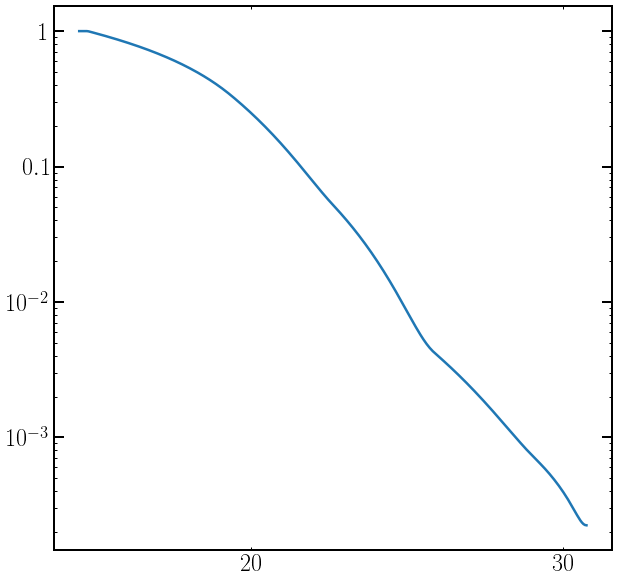

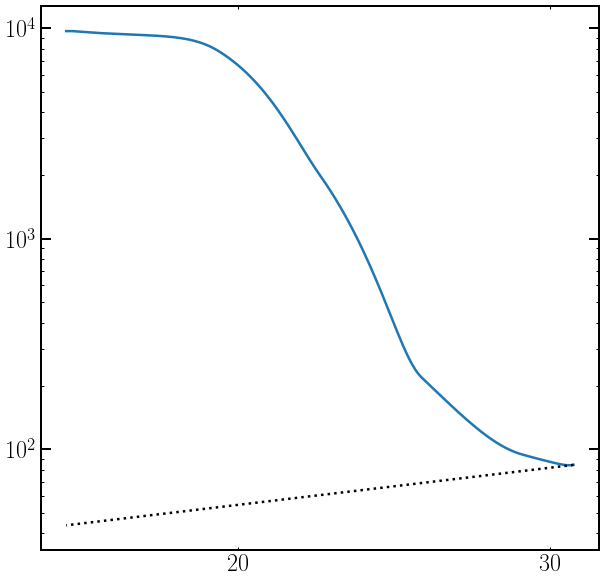

In [14]:
plt.figure()
# plt.plot(a[3].rs, a[0])
plt.plot(b[3].rs, b[0])
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')


plt.figure()
# plt.plot(a[3].rs, a[1]/phys.kB)
plt.plot(b[3].rs, b[1]/phys.kB)
plt.plot(b[3].rs, phys.TCMB(b[3].rs)/phys.kB, 'k:')
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')


In [15]:
a[0]
a[3].rs[1:]

NameError: name 'a' is not defined

In [ ]:
a = 2
str(a)